In [1]:

import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import os
import sys
import argparse
os.chdir('../')
sys.path.append('./')
os.getcwd()
from models.swinjscc import SWINJSCC 
from models.djsccn import DJSCCN_CIFAR
from models.eDjscc import *
import matplotlib.pyplot as plt
from utils.misc_utils import get_psnr, image_normalization

/home/namdeptrai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--out', type=str, default='./out',
                         help="Path to save outputs")
parser.add_argument("--ds", type=str, default='cifar10',
                    help="Dataset")
parser.add_argument("--base_snr", type=float, default=10,
                    help="SNR during train")
parser.add_argument('--channel_type', default='AWGN', type=str,
                    choices=['AWGN', 'Rayleigh'], help='channel')
parser.add_argument("--recl", type=str, default='mse',
                    help="Reconstruction Loss")
parser.add_argument("--clsl", type=str, default='ce',
                    help="Classification Loss")
parser.add_argument("--disl", type=str, default='kl',
                    help="Invariance and Variance Loss")
parser.add_argument("--lr", type=float, default=0.01,
                    help="Inner learning Rate")

# Loss Setting
parser.add_argument("--cls-coeff", type=float, default=0.5,
                    help="Coefficient for Classification Loss")
parser.add_argument("--rec-coeff", type=float, default=1,
                    help="Coefficient for Reconstruction Loss")
parser.add_argument("--inv-coeff", type=float, default=0.2,
                    help="Coefficient for Invariant Loss")
parser.add_argument("--var-coeff", type=float, default=0.2,
                    help="Coefficient for Variant Loss")

# Model Setting
parser.add_argument("--inv-cdim", type=int, default=32,
                    help="Channel dimension for invariant features")
parser.add_argument("--var-cdim", type=int, default=32,
                    help="Channel dimension for variant features")

# VAE Setting
parser.add_argument("--vae", action="store_true",
                    help="vae switch")
parser.add_argument("--kld-coeff", type=float, default=0.00025,
                    help="VAE Weight Coefficient")

# Meta Setting
parser.add_argument("--bs", type=int, default=128,
                    help="#batch size")
parser.add_argument("--wk", type=int, default=os.cpu_count(),
                    help="#number of workers")
parser.add_argument("--out-e", type=int, default=1,
                    help="#number of epochs")
parser.add_argument("--dv", type=int, default=0,
                    help="Index of GPU")
parser.add_argument("--device", type=bool, default=True,
                    help="Return device or not")
parser.add_argument("--operator", type=str, default='window',
                    help="Operator for Pycharm")

# LOGGING
parser.add_argument('--wandb', action='store_true',
                    help='toggle to use wandb for online saving')
parser.add_argument('--log', action='store_true',
                    help='toggle to use tensorboard for offline saving')
parser.add_argument('--wandb_prj', type=str, default="SemCom-",
                    help='toggle to use wandb for online saving')
parser.add_argument('--wandb_entity', type=str, default="scalemind",
                    help='toggle to use wandb for online saving')
parser.add_argument("--verbose", action="store_true",
                    help="printout mode")
parser.add_argument("--algo", type=str, default="eDJSCC",
                    help="necst/djsccf mode")

# RUNNING
parser.add_argument('--train_flag', type=bool, default=True,
                        help='Training mode')
parser.add_argument('--num_iter', type=int, default=10,help='Number of iterations for eDJSCC')
args = parser.parse_args(args=[])
ratio_list = [1/6]
snr_list = [20]
args.snr_list = snr_list
args.ratio = ratio_list
args.pass_channel = True
"""Nếu dùng cifar10 train thì là (3,32,32) và downsample=2"""
# args.image_dims = (3, 256, 256)
# args.downsample = 4
if args.ds == 'cifar10':
    args.image_dims = (3, 32, 32)
    args.downsample = 2
# elif args.ds == 'DIV2K':
#     args.image_dims = (3, 256, 256)
#     args.downsample = 4
# else:  # ví dụ mnist
#     args.image_dims = (1, 28, 28)
#     args.downsample = 2

# Kích thước latent channels
args.channel_number = int(args.var_cdim)

# # Unpack spatial dims
_, H, W = args.image_dims
# args.encoder_kwargs = dict(
#                 img_size=(H,W), patch_size=2, in_chans=3,
#                 embed_dims=[128, 192, 256, 320], depths=[2, 2, 2, 2], num_heads=[4, 6, 8, 10], C=args.channel_number,
#                 window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
#                 norm_layer=nn.LayerNorm, patch_norm=True,
#             )
# args.decoder_kwargs = dict(
#                 img_size=(H,W),
#                 embed_dims=[320, 256, 192, 128], depths=[2, 2, 2, 2], num_heads=[10, 8, 6, 4], C=args.channel_number,
#                 window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
#                 norm_layer=nn.LayerNorm, patch_norm=True,
#             )
"""Nếu dùng CIFAR10 train thì thay tham số của encoder và decoder lại"""
# Thiết lập encoder_kwargs
if args.ds == 'cifar10':
        args.encoder_kwargs = dict(
        img_size=(H, W), patch_size=2, in_chans=args.image_dims[0],
        embed_dims=[64, 128], depths=[2, 4], num_heads=[4, 8],
        C=args.channel_number,
        window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
        norm_layer=nn.LayerNorm,  # Sử dụng nn.LayerNorm thay vì None
        patch_norm=True
    )

    # Thiết lập decoder_kwargs
        args.decoder_kwargs = dict(
        img_size=(H, W),
        embed_dims=[128, 64], depths=[4, 2], num_heads=[8, 4],
        C=args.channel_number,
        window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
        norm_layer=nn.LayerNorm,  # Sử dụng nn.LayerNorm thay vì None
        patch_norm=True
    )
# elif args.ds == 'DIV2K':
#     if args.model_size == 'small':
#         args.encoder_kwargs = dict(
#                 img_size=(H,W), patch_size=2, in_chans=3,
#                 embed_dims=[128, 192, 256, 320], depths=[2, 2, 2, 2], num_heads=[4, 6, 8, 10], C=args.channel_number,
#                 window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
#                 norm_layer=nn.LayerNorm, patch_norm=True,
#             )
#         args.decoder_kwargs = dict(
#                 img_size=(H,W),
#                 embed_dims=[320, 256, 192, 128], depths=[2, 2, 2, 2], num_heads=[10, 8, 6, 4], C=args.channel_number,
#                 window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
#                 norm_layer=nn.LayerNorm, patch_norm=True,
#             )

### Eval para

In [3]:
channel = 'AWGN'

# Thay model 
saved = '/home/namdeptrai/djscc/SemCom_new (copy)/SemCom-Pytorch/out/checkpoints/CIFAR10_13_[0.16666666666666666]_AWGN_07h00m35s_on_May_14_2025/CIFAR10_eDJSCC_epoch_4.pkl'

args.base_snr = 2000
test_image_dir = '/home/namdeptrai/djscc/SemCom_new (copy)/SemCom-Pytorch/demo/kodim23.png'
times = 10

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
test_image = Image.open(test_image_dir)
test_image.load()
# print(f"[INFO] Original image size (W x H): {test_image.size}")
test_image = transform(test_image)
print(test_image.size())

torch.Size([3, 512, 768])


### Trans from nn.DataParallel to nn.Module

In [ ]:
state_dict = torch.load(saved)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','') # remove `module.`
    new_state_dict[name] = v
# model.load_state_dict(torch.load(saved))


### Load model from checkpoint

In [6]:
file_name = os.path.basename(os.path.dirname(saved))
in_channel = 3
print("Input shape:", test_image.shape)
#model = eDJSCC(args, in_channel, 10)
model = SWINJSCC(args)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(new_state_dict)
#model.change_channel(channel, args.base_snr)

Input shape: torch.Size([3, 512, 768])


TypeError: SWINJSCC.__init__() missing 2 required positional arguments: 'in_channel' and 'class_num'

### Eval for times

num_iter 10
snr: 50
stddev: 0.0031622776601683794
num iter: 0
Iteration 0: rdfadsfs size: tensor([[[[ 0.1999,  0.6095,  1.4625,  ...,  0.6280,  0.1584,  0.4962],
          [ 1.0105,  1.1045,  0.2271,  ..., -0.1967, -0.7857, -0.6028],
          [ 0.6664,  0.9983,  0.7955,  ..., -0.2220, -0.6595, -0.6696],
          ...,
          [ 0.3228,  1.5166,  1.5485,  ...,  0.5704,  0.0876, -0.6798],
          [ 0.0907,  0.4673,  1.6374,  ...,  0.7180, -0.3713, -0.5898],
          [ 0.9224,  0.8925,  1.6514,  ...,  0.8551,  0.4551, -0.3095]],

         [[-0.9320, -0.5562,  0.1577,  ...,  0.4146,  0.6706,  0.1070],
          [-0.6817, -0.0187,  0.1053,  ...,  0.9060,  1.0901,  0.5459],
          [-0.7105, -0.4346, -0.4993,  ...,  0.1786,  0.2331,  0.6727],
          ...,
          [-1.4012, -0.2317, -1.1277,  ...,  0.0890, -0.6389,  0.1188],
          [-0.8924, -0.6642,  0.1432,  ...,  0.1825, -0.1512,  0.3435],
          [-1.1829, -0.5610,  0.1721,  ...,  0.3003, -0.6176,  0.6577]],

         [[ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96634835].


x_hat size: torch.Size([1, 3, 512, 768])
average psnr is 7.705912780761719 for 10 times on kodim23.png


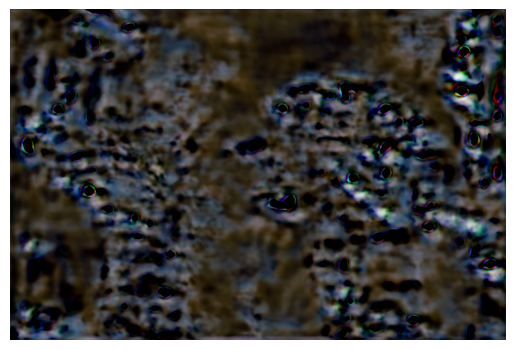

In [ ]:
psnr_all = 0.0
#with torch.no_grad():
stddev = 10 ** (-0.05 * args.base_snr)
print("num_iter", args.num_iter)
for i in range(times):
        # print(test_image.size())
    if test_image.dim() == 3:
        test_image = test_image.unsqueeze(0)

    model = model.to(device)
    test_image = test_image.to(device)

    demo_image = model(test_image)
    #print("demo_image size", demo_image)
    if isinstance(demo_image, (tuple, list)):
        demo_image = demo_image[0]
    with torch.no_grad():
        demo_image = image_normalization('denormalization')(demo_image)
        gt = image_normalization('denormalization')(test_image)
    
        #print("gt size", gt)
        psnr_all += get_psnr(demo_image, gt)
    demo_image = image_normalization('normalization')(demo_image)
    demo_image = torch.cat([test_image, demo_image], dim=1)
    demo_image = demo_image.cpu().numpy()
demo_image = demo_image[0]
demo_image = demo_image[3:, :, :]
plt.imshow(demo_image.transpose(1, 2, 0))
plt.axis('off')
print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))

